Crea il file di estrazione delle perdite (OdL)

In [1]:
import uuid
import re, os
from path import Path
from pprint import pprint
from tqdm import tqdm

import pytz
import arrow 

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd


plt.rcParams['figure.figsize'] = (15, 5) # bigger plots
plt.style.use('fivethirtyeight')
%matplotlib inline
%precision 4

'%.4f'

In [2]:
from matplotlib.pyplot import imread

In [3]:
##### Estrazione OdL da Maximo
import pyodbc

server = '' 
database = '' 
username = '' 
password = '' 
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cur = conn.cursor()

query_wo = """
select 
w.workorderid, w.wonum, w.location, w.description, 
w.g_comune comune, w.g_localita localita, w.g_via via, w.g_civico civico, 
c.g_comune comune_loc,
w.g_materiale materiale, w.g_diametro diametro, w.g_lsostituito l_intervento , 
w.status, w.reportdate, year(w.reportdate) anno,
w.g_coordx x, w.g_coordy y, w.actservcost serv_cost
from dbo.workorder w
left join g_comuni c on c.g_numcomune=left(w.location,2)
where 
w.worktype = 'MANCORR' and w.g_coordx>0 and w.g_coordy>0
and w.problemcode in ('PR_IDR013','PR_IDR012')
and w.woclass = 'WORKORDER' 
and w.location like '__A_____'
and w.wonum in (select refwo from poline 
                where 
                left(itemnum,13) in ('TT.AC.002.004','TT.AC.002.005','TT.AC.002.003') --riparazione perdita
                or ( itemnum like 'TT.AC.T%' and orderunit = 'M' ) --sostituzione tubazione
                )     
; """

df = pd.read_sql_query(query_wo, conn)
conn.commit()
cur.close()
conn.close()

df

,workorderid,wonum,location,description,comune,localita,via,civico,comune_loc,materiale,diametro,l_intervento,status,reportdate,anno,x,y,serv_cost
0,434549,15ODL105517,38A05A01,Perdita acqua dalla rete montedivalli podenzana,PODENZANA,PODENZANA,Genova 0,0,PODENZANA,PEAD,110.0,0.0,CLOSE,2015-05-15 18:14:00.000,2015,568620.4140,4.893905e+06,286.57
1,449895,15ODL121318,45A07A04,perdita su adduttrice serbatoio giovagallo ese...,TRESANA,TRESANA,VIA BOLA 1,1,TRESANA,FERRO,90.0,0.0,CLOSE,2015-05-30 19:14:00.000,2015,569967.6850,4.898467e+06,220.99
2,522152,15ODL194112,39A01A03,PERDITA STRADALE,pontremoli,CODOLO,codolo,,PONTREMOLI,FERRO,50.0,0.0,CLOSE,2015-09-02 08:27:00.000,2015,566934.2751,4.913705e+06,227.51
3,526117,15ODL198239,39A01A18,rotture idriche addutrice serbatoio di s. marco,pontremoli,BASSONE,bassone,00,PONTREMOLI,ACCIAIO,125.0,0.0,CLOSE,2015-09-08 08:34:01.403,2015,567494.3848,4.914638e+06,645.88
4,569916,15ODL243824,45A14A08,scavo per inst valvola ricerca perdita su addu...,tresana,VILLECCHIA,villecchia,snc,TRESANA,FERRO,75.0,0.0,CLOSE,2015-11-03 08:09:34.160,2015,570369.9337,4.901474e+06,234.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35057,2877674,22ODL181106,34A02R12,Ricerca perdita su rete fontanaccio alto,PIAZZA AL SERCHIO,PIAZZA AL SERCHIO,LOCALITA' FONTANACCIO n. 0,None,PIAZZA AL SERCHIO,PEAD,32.0,1.0,COMP,2022-03-11 14:45:48.847,2022,604037.9532,4.893039e+06,0.00
35058,2882050,22ODL185438,07A01R05,Perdita acqua dalla rete,CAMAIORE,CAMAIORE,VIA FONDI 114,None,CAMAIORE,PEAD,63.0,0.0,COMP,2022-03-12 11:36:00.000,2022,604909.6800,4.864743e+06,0.00
35059,2882055,22ODL185443,07A01R05,Perdita acqua dalla rete,CAMAIORE,CAMAIORE,VIA VERDINA 43,None,CAMAIORE,PEAD,75.0,0.0,COMP,2022-03-13 16:13:00.000,2022,604834.5600,4.866056e+06,0.00
35060,2882287,22ODL185673,07A01R05,PERDITA STRADALE SEGNALATA DA DITTA,CAMAIORE,CAMAIORE CENTRO,FONDI 163,None,CAMAIORE,PEAD,63.0,0.0,COMP,2022-03-14 16:18:16.903,2022,604841.8000,4.864596e+06,0.00


comune_loc  anno
CAMAIORE    2020    10276.01
CARRARA     2020     9800.65
MASSA       2020    57849.97
MASSAROSA   2020    12859.76
Name: serv_cost, dtype: float64

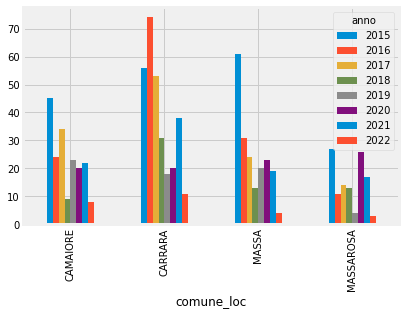

In [40]:
##### Filtro solo da un certo diametro in su
df = df.loc[df['diametro']>=90]

#### guardo la distribuzione dei dati degli OdL sui comuni principali
dfp = df.loc[ (df['comune_loc'] == 'MASSA') | (df['comune_loc'] == 'CARRARA') | (df['comune_loc'] == 'CAMAIORE') | (df['comune_loc'] == 'MASSAROSA') ]
pd.crosstab(dfp['comune_loc'],dfp['anno']).plot.bar()
dfp.loc[dfp['anno']==2020].groupby(['comune_loc','anno'])['serv_cost'].sum()

In [4]:
##### Estrazione dati pioggia SIR
import psycopg2 as pg

server = ""
port = ""
database = ""
username = ""
password = ""
conn_sir = pg.connect(host=server, port=port, dbname=database, user=username, password=password)
cur_sir = conn_sir.cursor()

query_sir = """
select pi.*, p.geom
from main.piogge_24h pi
left join main.pluviometri p on p.codice=pi.codice
where p.provincia in ('LU','MS','PT') and p.geom is not null
; """

gdf_sir = gpd.read_postgis(query_sir, conn_sir)
conn_sir.commit()
cur_sir.close()
conn_sir.close()

gdf_sir

,id,codice,data_evento,mm,geom
0,2,TOS02000161,2016-02-23,18.2,POINT (10.30965 44.25602)
1,12,TOS02004091,2016-02-16,7.4,POINT (10.25948 43.86767)
2,15,TOS01001269,2017-04-04,1.8,POINT (11.00385 43.88455)
3,17,TOS02000494,2020-10-29,0.4,POINT (10.37013 43.92008)
4,20,TOS09000022,2017-03-02,8.2,POINT (9.82325 44.33964)
...,...,...,...,...,...
97087,297620,TOS03001550,2021-12-21,0.2,POINT (10.71124 43.99490)
97088,297623,TOS02000108,2021-05-05,0.8,POINT (10.33614 43.96902)
97089,297634,TOS11000101,2021-10-21,43.2,POINT (9.89275 44.36949)
97090,297637,TOS02000221,2021-02-17,0.2,POINT (10.44717 44.21055)


In [5]:
###### Unisco i dati degli OdL a quelli di pioggia
gdf_wo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y'], crs='EPSG:25832'))

if gdf_sir.crs.to_epsg() == 25832 :
    print("SR corretto")
else:
    gdf_sir = gdf_sir.to_crs('EPSG:25832')

gdf_wo_sir = gpd.sjoin_nearest(gdf_wo, gdf_sir)
gdf_wo_sir = gdf_wo_sir.reset_index()

gdf_wo_sir

,workorderid,wonum,location,description,comune,localita,via,civico,comune_loc,materiale,...,anno,x,y,serv_cost,geometry,index_right,id,codice,data_evento,mm
0,434549,15ODL105517,38A05A01,Perdita acqua dalla rete montedivalli podenzana,PODENZANA,PODENZANA,Genova 0,0,PODENZANA,PEAD,...,2015,568620.4140,4.893905e+06,286.57,POINT (568620.414 4893904.838),40267,124952,TOS11000099,2017-02-04,44.6
1,449895,15ODL121318,45A07A04,perdita su adduttrice serbatoio giovagallo ese...,TRESANA,TRESANA,VIA BOLA 1,1,TRESANA,FERRO,...,2015,569967.6850,4.898467e+06,220.99,POINT (569967.685 4898467.328),40267,124952,TOS11000099,2017-02-04,44.6
15,1529234,18ODL343588,38A05A01,perdita rete eseguita il 13 08 2018,podenzana,CASA BORSI,casa borsi,None,PODENZANA,PEAD,...,2018,568771.9693,4.893859e+06,294.19,POINT (568771.969 4893858.988),40267,124952,TOS11000099,2017-02-04,44.6
27,1769856,19ODL213506,38A05A10,perdita rete,podenzana,SERRA,serra,None,PODENZANA,FERRO,...,2019,570371.1121,4.895450e+06,512.14,POINT (570371.112 4895449.985),40267,124952,TOS11000099,2017-02-04,44.6
28,1775391,19ODL219126,38A05A01,Mancata fornitura idrica ( causa perdita su ad...,PODENZANA,MONTEDIVALLI,VIA PAGLIADICCIO 37,None,PODENZANA,PEAD,...,2019,568772.9654,4.894045e+06,324.18,POINT (568772.965 4894045.116),40267,124952,TOS11000099,2017-02-04,44.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32695,2865344,22ODL169050,03A16R57,Perdita acqua dalla rete,BAGNI DI LUCCA,SAN GEMIGNANO,San gemignano,None,BAGNI DI LUCCA,PEAD,...,2022,665294.8100,4.814775e+06,0.00,POINT (665294.810 4814774.970),94965,291600,TOS01001629,2021-02-24,0.2
32695,2865344,22ODL169050,03A16R57,Perdita acqua dalla rete,BAGNI DI LUCCA,SAN GEMIGNANO,San gemignano,None,BAGNI DI LUCCA,PEAD,...,2022,665294.8100,4.814775e+06,0.00,POINT (665294.810 4814774.970),29611,91982,TOS01001629,2016-12-28,0.2
32695,2865344,22ODL169050,03A16R57,Perdita acqua dalla rete,BAGNI DI LUCCA,SAN GEMIGNANO,San gemignano,None,BAGNI DI LUCCA,PEAD,...,2022,665294.8100,4.814775e+06,0.00,POINT (665294.810 4814774.970),96481,295986,TOS01001629,2021-12-27,7.4
32695,2865344,22ODL169050,03A16R57,Perdita acqua dalla rete,BAGNI DI LUCCA,SAN GEMIGNANO,San gemignano,None,BAGNI DI LUCCA,PEAD,...,2022,665294.8100,4.814775e+06,0.00,POINT (665294.810 4814774.970),81661,252549,TOS01001629,2021-09-21,0.2


In [26]:
##### Calcolo la distanza in giorni dall'ultima pioggia, prendo gli OdL da escludere (quelli quando ha piovuto)
gdf_wo_sir['time_distance'] = pd.to_datetime(gdf_wo_sir['reportdate'])-pd.to_datetime(gdf_wo_sir['data_evento'])

gdf_wo_sir = gdf_wo_sir.loc[(gdf_wo_sir['mm'] > 2.00 ) & (gdf_wo_sir['time_distance'] < '2 days') & (gdf_wo_sir['time_distance'] > '-6 days')]

df_wo_sir = pd.DataFrame(gdf_wo_sir['workorderid'].unique(),columns=['workorderid'])
df_wo_sir

In [38]:
###### Escludo gli OdL dove è piovuto qualche giorno prima 
df = df[~df.workorderid.isin(df_wo_sir['workorderid'])]

df

,workorderid,wonum,location,description,comune,localita,via,civico,comune_loc,materiale,diametro,l_intervento,status,reportdate,anno,x,y,serv_cost,geometry
0,434549,15ODL105517,38A05A01,Perdita acqua dalla rete montedivalli podenzana,PODENZANA,PODENZANA,Genova 0,0,PODENZANA,PEAD,110.0,0.0,CLOSE,2015-05-15 18:14:00.000,2015,568620.4140,4.893905e+06,286.57,POINT (568620.414 4893904.838)
1,449895,15ODL121318,45A07A04,perdita su adduttrice serbatoio giovagallo ese...,TRESANA,TRESANA,VIA BOLA 1,1,TRESANA,FERRO,90.0,0.0,CLOSE,2015-05-30 19:14:00.000,2015,569967.6850,4.898467e+06,220.99,POINT (569967.685 4898467.328)
2,522152,15ODL194112,39A01A03,PERDITA STRADALE,pontremoli,CODOLO,codolo,,PONTREMOLI,FERRO,50.0,0.0,CLOSE,2015-09-02 08:27:00.000,2015,566934.2751,4.913705e+06,227.51,POINT (566934.275 4913705.225)
3,526117,15ODL198239,39A01A18,rotture idriche addutrice serbatoio di s. marco,pontremoli,BASSONE,bassone,00,PONTREMOLI,ACCIAIO,125.0,0.0,CLOSE,2015-09-08 08:34:01.403,2015,567494.3848,4.914638e+06,645.88,POINT (567494.385 4914638.397)
4,569916,15ODL243824,45A14A08,scavo per inst valvola ricerca perdita su addu...,tresana,VILLECCHIA,villecchia,snc,TRESANA,FERRO,75.0,0.0,CLOSE,2015-11-03 08:09:34.160,2015,570369.9337,4.901474e+06,234.59,POINT (570369.934 4901473.615)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35057,2877674,22ODL181106,34A02R12,Ricerca perdita su rete fontanaccio alto,PIAZZA AL SERCHIO,PIAZZA AL SERCHIO,LOCALITA' FONTANACCIO n. 0,None,PIAZZA AL SERCHIO,PEAD,32.0,1.0,COMP,2022-03-11 14:45:48.847,2022,604037.9532,4.893039e+06,0.00,POINT (604037.953 4893039.435)
35058,2882050,22ODL185438,07A01R05,Perdita acqua dalla rete,CAMAIORE,CAMAIORE,VIA FONDI 114,None,CAMAIORE,PEAD,63.0,0.0,COMP,2022-03-12 11:36:00.000,2022,604909.6800,4.864743e+06,0.00,POINT (604909.680 4864743.220)
35059,2882055,22ODL185443,07A01R05,Perdita acqua dalla rete,CAMAIORE,CAMAIORE,VIA VERDINA 43,None,CAMAIORE,PEAD,75.0,0.0,COMP,2022-03-13 16:13:00.000,2022,604834.5600,4.866056e+06,0.00,POINT (604834.560 4866055.510)
35060,2882287,22ODL185673,07A01R05,PERDITA STRADALE SEGNALATA DA DITTA,CAMAIORE,CAMAIORE CENTRO,FONDI 163,None,CAMAIORE,PEAD,63.0,0.0,COMP,2022-03-14 16:18:16.903,2022,604841.8000,4.864596e+06,0.00,POINT (604841.800 4864596.470)


# Transforming cols

In [43]:
# turn the italian datetime into pandas utc datetime
def parse_dttm_b(s):
    if isinstance(s,str):
        return arrow.get(s,'YYYY-MM-DD HH:mm:ss',tzinfo='Europe/Berlin').astimezone(pytz.utc).isoformat()
    else:
        return s

import pytz
df['reportdate']=df['reportdate'].apply(lambda x: x.tz_localize(pytz.timezone('Europe/Berlin'))).apply(lambda x: x.tz_convert(pytz.timezone('UTC')))

## Save to CSV

In [44]:
import os

file_path = '../data/leak_dataset/'
csv_file = file_path+'leaks.csv'

df.to_csv(csv_file, date_format='iso')

df

,workorderid,wonum,location,description,comune,localita,via,civico,comune_loc,materiale,diametro,l_intervento,status,reportdate,anno,x,y,serv_cost,geometry
0,434549,15ODL105517,38A05A01,Perdita acqua dalla rete montedivalli podenzana,PODENZANA,PODENZANA,Genova 0,0,PODENZANA,PEAD,110.0,0.0,CLOSE,2015-05-15 16:14:00+00:00,2015,568620.4140,4.893905e+06,286.57,POINT (568620.414 4893904.838)
1,449895,15ODL121318,45A07A04,perdita su adduttrice serbatoio giovagallo ese...,TRESANA,TRESANA,VIA BOLA 1,1,TRESANA,FERRO,90.0,0.0,CLOSE,2015-05-30 17:14:00+00:00,2015,569967.6850,4.898467e+06,220.99,POINT (569967.685 4898467.328)
3,526117,15ODL198239,39A01A18,rotture idriche addutrice serbatoio di s. marco,pontremoli,BASSONE,bassone,00,PONTREMOLI,ACCIAIO,125.0,0.0,CLOSE,2015-09-08 06:34:01.403000+00:00,2015,567494.3848,4.914638e+06,645.88,POINT (567494.385 4914638.397)
9,815762,16ODL315760,39A01A04,PERDITA STRADALE,pontremoli,DOZZANO,dozzano,,PONTREMOLI,PEAD,110.0,0.0,CLOSE,2016-09-05 11:59:11.637000+00:00,2016,568821.4487,4.912968e+06,539.55,POINT (568821.449 4912968.289)
44,2621776,21ODL308113,39A01A08,Mancata fornitura idrica- PERDITA ACQUA DALLA ...,PONTREMOLI,LOCALITA' COSTA S. NICOLO' 23,LOCALITA' COSTA S. NICOLO' 23,None,PONTREMOLI,FERRO,90.0,0.0,CLOSE,2021-07-17 05:44:00+00:00,2021,567243.1819,4.915042e+06,1057.92,POINT (567243.182 4915041.675)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34754,2621532,21ODL307918,07A01R05,Perdita via quattro novembre 51,CAMAIORE,CAMAIORE CENTRO,quattro novembre 51,51,CAMAIORE,FERRO,90.0,0.0,CLOSE,2021-07-16 05:40:11.870000+00:00,2021,604645.6739,4.865770e+06,411.85,POINT (604645.674 4865770.486)
34760,2626643,21ODL312931,07A01R05,perdita acqua dalla rete,CAMAIORE,CAMAIORE CENTRO,VIA DI MEZZO 102,None,CAMAIORE,PEAD,90.0,0.0,CLOSE,2021-07-19 04:50:00+00:00,2021,604586.3295,4.866877e+06,607.40,POINT (604586.329 4866877.086)
34873,2674832,21ODL359928,28A01R08,Perdita di acqua vista da nostro personale,MASSAROSA,PIAN DEL QUERCIONE,Montramito,None,MASSAROSA,FERRO,125.0,0.0,CLOSE,2021-09-04 15:13:31.657000+00:00,2021,604364.1500,4.859748e+06,776.14,POINT (604364.150 4859747.980)
34881,2679778,21ODL364825,18A01R01,PERDITA STRADALE,FILATTIERA,FILATTIERA,PONTE PROVINCILE,24,FILATTIERA,FERRO,90.0,0.0,CLOSE,2021-09-07 09:46:49.460000+00:00,2021,574466.6363,4.909024e+06,653.46,POINT (574466.636 4909023.619)


## Converting CRS

Convert to the google maps CRS. 

It looks like the crs is pyproj.Proj(init='EPSG:6578') and it has to be multiplied by 1200.0/3937 first to convert to meters

In [45]:
from pyproj import Transformer

# 'EPSG:25832' # ETRS 89
# 'EPSG:3857' #  WGS84 Web Mercator (Auxiliary Sphere) 

transformer = Transformer.from_crs('EPSG:25832', 'EPSG:3857')

def convert_to_3857(X,Y):
    return transformer.transform(X, Y)

x,y=convert_to_3857(df.x.values, df.y.values)
df['x']=x
df['y']=y

df

,workorderid,wonum,location,description,comune,localita,via,civico,comune_loc,materiale,diametro,l_intervento,status,reportdate,anno,x,y,serv_cost,geometry
0,434549,15ODL105517,38A05A01,Perdita acqua dalla rete montedivalli podenzana,PODENZANA,PODENZANA,Genova 0,0,PODENZANA,PEAD,110.0,0.0,CLOSE,2015-05-15 16:14:00+00:00,2015,1.097467e+06,5.495690e+06,286.57,POINT (568620.414 4893904.838)
1,449895,15ODL121318,45A07A04,perdita su adduttrice serbatoio giovagallo ese...,TRESANA,TRESANA,VIA BOLA 1,1,TRESANA,FERRO,90.0,0.0,CLOSE,2015-05-30 17:14:00+00:00,2015,1.099411e+06,5.502049e+06,220.99,POINT (569967.685 4898467.328)
3,526117,15ODL198239,39A01A18,rotture idriche addutrice serbatoio di s. marco,pontremoli,BASSONE,bassone,00,PONTREMOLI,ACCIAIO,125.0,0.0,CLOSE,2015-09-08 06:34:01.403000+00:00,2015,1.096196e+06,5.524731e+06,645.88,POINT (567494.385 4914638.397)
9,815762,16ODL315760,39A01A04,PERDITA STRADALE,pontremoli,DOZZANO,dozzano,,PONTREMOLI,PEAD,110.0,0.0,CLOSE,2016-09-05 11:59:11.637000+00:00,2016,1.098026e+06,5.522370e+06,539.55,POINT (568821.449 4912968.289)
44,2621776,21ODL308113,39A01A08,Mancata fornitura idrica- PERDITA ACQUA DALLA ...,PONTREMOLI,LOCALITA' COSTA S. NICOLO' 23,LOCALITA' COSTA S. NICOLO' 23,None,PONTREMOLI,FERRO,90.0,0.0,CLOSE,2021-07-17 05:44:00+00:00,2021,1.095851e+06,5.525300e+06,1057.92,POINT (567243.182 4915041.675)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34754,2621532,21ODL307918,07A01R05,Perdita via quattro novembre 51,CAMAIORE,CAMAIORE CENTRO,quattro novembre 51,51,CAMAIORE,FERRO,90.0,0.0,CLOSE,2021-07-16 05:40:11.870000+00:00,2021,1.147021e+06,5.455793e+06,411.85,POINT (604645.674 4865770.486)
34760,2626643,21ODL312931,07A01R05,perdita acqua dalla rete,CAMAIORE,CAMAIORE CENTRO,VIA DI MEZZO 102,None,CAMAIORE,PEAD,90.0,0.0,CLOSE,2021-07-19 04:50:00+00:00,2021,1.146962e+06,5.457335e+06,607.40,POINT (604586.329 4866877.086)
34873,2674832,21ODL359928,28A01R08,Perdita di acqua vista da nostro personale,MASSAROSA,PIAN DEL QUERCIONE,Montramito,None,MASSAROSA,FERRO,125.0,0.0,CLOSE,2021-09-04 15:13:31.657000+00:00,2021,1.146499e+06,5.447423e+06,776.14,POINT (604364.150 4859747.980)
34881,2679778,21ODL364825,18A01R01,PERDITA STRADALE,FILATTIERA,FILATTIERA,PONTE PROVINCILE,24,FILATTIERA,FERRO,90.0,0.0,CLOSE,2021-09-07 09:46:49.460000+00:00,2021,1.105849e+06,5.516756e+06,653.46,POINT (574466.636 4909023.619)


## To geojson

In [46]:
# # converting to geojson
# from collections import OrderedDict
# def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
#     geojson = {'type':'FeatureCollection', 'features':[], "crs": {"type": "name", "properties": {"name": "EPSG:3857"}}}
#     for _, row in df.iterrows():
#         feature = {'type':'Feature',
#                    'properties':OrderedDict(),
#                    'geometry':{'type':'Point',
#                                'coordinates':[]}}
#         feature['geometry']['coordinates'] = [row[lon],row[lat]]
#         for prop in properties:
#             feature['properties'][prop] = row[prop]
#         geojson['features'].append(feature)
#     return geojson

# cols = df.columns.drop(['x','y'])
# geoj = df_to_geojson(df.copy(),properties=cols,lat='y',lon='x')
# gdf = gpd.GeoDataFrame.from_features(geoj['features'], crs='epsg:3857')

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y'], crs='EPSG:3857'))
gdf = gdf.to_crs(epsg=4326) # geojson only supports this by default
gdf

,workorderid,wonum,location,description,comune,localita,via,civico,comune_loc,materiale,diametro,l_intervento,status,reportdate,anno,x,y,serv_cost,geometry
0,434549,15ODL105517,38A05A01,Perdita acqua dalla rete montedivalli podenzana,PODENZANA,PODENZANA,Genova 0,0,PODENZANA,PEAD,110.0,0.0,CLOSE,2015-05-15 16:14:00+00:00,2015,1.097467e+06,5.495690e+06,286.57,POINT (9.85871 44.19513)
1,449895,15ODL121318,45A07A04,perdita su adduttrice serbatoio giovagallo ese...,TRESANA,TRESANA,VIA BOLA 1,1,TRESANA,FERRO,90.0,0.0,CLOSE,2015-05-30 17:14:00+00:00,2015,1.099411e+06,5.502049e+06,220.99,POINT (9.87618 44.23608)
3,526117,15ODL198239,39A01A18,rotture idriche addutrice serbatoio di s. marco,pontremoli,BASSONE,bassone,00,PONTREMOLI,ACCIAIO,125.0,0.0,CLOSE,2015-09-08 06:34:01.403000+00:00,2015,1.096196e+06,5.524731e+06,645.88,POINT (9.84730 44.38188)
9,815762,16ODL315760,39A01A04,PERDITA STRADALE,pontremoli,DOZZANO,dozzano,,PONTREMOLI,PEAD,110.0,0.0,CLOSE,2016-09-05 11:59:11.637000+00:00,2016,1.098026e+06,5.522370e+06,539.55,POINT (9.86374 44.36673)
44,2621776,21ODL308113,39A01A08,Mancata fornitura idrica- PERDITA ACQUA DALLA ...,PONTREMOLI,LOCALITA' COSTA S. NICOLO' 23,LOCALITA' COSTA S. NICOLO' 23,None,PONTREMOLI,FERRO,90.0,0.0,CLOSE,2021-07-17 05:44:00+00:00,2021,1.095851e+06,5.525300e+06,1057.92,POINT (9.84420 44.38554)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34754,2621532,21ODL307918,07A01R05,Perdita via quattro novembre 51,CAMAIORE,CAMAIORE CENTRO,quattro novembre 51,51,CAMAIORE,FERRO,90.0,0.0,CLOSE,2021-07-16 05:40:11.870000+00:00,2021,1.147021e+06,5.455793e+06,411.85,POINT (10.30386 43.93762)
34760,2626643,21ODL312931,07A01R05,perdita acqua dalla rete,CAMAIORE,CAMAIORE CENTRO,VIA DI MEZZO 102,None,CAMAIORE,PEAD,90.0,0.0,CLOSE,2021-07-19 04:50:00+00:00,2021,1.146962e+06,5.457335e+06,607.40,POINT (10.30334 43.94759)
34873,2674832,21ODL359928,28A01R08,Perdita di acqua vista da nostro personale,MASSAROSA,PIAN DEL QUERCIONE,Montramito,None,MASSAROSA,FERRO,125.0,0.0,CLOSE,2021-09-04 15:13:31.657000+00:00,2021,1.146499e+06,5.447423e+06,776.14,POINT (10.29917 43.88345)
34881,2679778,21ODL364825,18A01R01,PERDITA STRADALE,FILATTIERA,FILATTIERA,PONTE PROVINCILE,24,FILATTIERA,FERRO,90.0,0.0,CLOSE,2021-09-07 09:46:49.460000+00:00,2021,1.105849e+06,5.516756e+06,653.46,POINT (9.93401 44.33066)


In [47]:
# the geopandas to_json can't handle dates, so lets manually convert them to isoformat
def to_isoformat(t):
    try:
        return t.isoformat()
    except Exception as e:
        return None

gdf['reportdate']=gdf['reportdate'].apply(to_isoformat) #.astype(str)

gdf

,workorderid,wonum,location,description,comune,localita,via,civico,comune_loc,materiale,diametro,l_intervento,status,reportdate,anno,x,y,serv_cost,geometry
0,434549,15ODL105517,38A05A01,Perdita acqua dalla rete montedivalli podenzana,PODENZANA,PODENZANA,Genova 0,0,PODENZANA,PEAD,110.0,0.0,CLOSE,2015-05-15T16:14:00+00:00,2015,1.097467e+06,5.495690e+06,286.57,POINT (9.85871 44.19513)
1,449895,15ODL121318,45A07A04,perdita su adduttrice serbatoio giovagallo ese...,TRESANA,TRESANA,VIA BOLA 1,1,TRESANA,FERRO,90.0,0.0,CLOSE,2015-05-30T17:14:00+00:00,2015,1.099411e+06,5.502049e+06,220.99,POINT (9.87618 44.23608)
3,526117,15ODL198239,39A01A18,rotture idriche addutrice serbatoio di s. marco,pontremoli,BASSONE,bassone,00,PONTREMOLI,ACCIAIO,125.0,0.0,CLOSE,2015-09-08T06:34:01.403000+00:00,2015,1.096196e+06,5.524731e+06,645.88,POINT (9.84730 44.38188)
9,815762,16ODL315760,39A01A04,PERDITA STRADALE,pontremoli,DOZZANO,dozzano,,PONTREMOLI,PEAD,110.0,0.0,CLOSE,2016-09-05T11:59:11.637000+00:00,2016,1.098026e+06,5.522370e+06,539.55,POINT (9.86374 44.36673)
44,2621776,21ODL308113,39A01A08,Mancata fornitura idrica- PERDITA ACQUA DALLA ...,PONTREMOLI,LOCALITA' COSTA S. NICOLO' 23,LOCALITA' COSTA S. NICOLO' 23,None,PONTREMOLI,FERRO,90.0,0.0,CLOSE,2021-07-17T05:44:00+00:00,2021,1.095851e+06,5.525300e+06,1057.92,POINT (9.84420 44.38554)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34754,2621532,21ODL307918,07A01R05,Perdita via quattro novembre 51,CAMAIORE,CAMAIORE CENTRO,quattro novembre 51,51,CAMAIORE,FERRO,90.0,0.0,CLOSE,2021-07-16T05:40:11.870000+00:00,2021,1.147021e+06,5.455793e+06,411.85,POINT (10.30386 43.93762)
34760,2626643,21ODL312931,07A01R05,perdita acqua dalla rete,CAMAIORE,CAMAIORE CENTRO,VIA DI MEZZO 102,None,CAMAIORE,PEAD,90.0,0.0,CLOSE,2021-07-19T04:50:00+00:00,2021,1.146962e+06,5.457335e+06,607.40,POINT (10.30334 43.94759)
34873,2674832,21ODL359928,28A01R08,Perdita di acqua vista da nostro personale,MASSAROSA,PIAN DEL QUERCIONE,Montramito,None,MASSAROSA,FERRO,125.0,0.0,CLOSE,2021-09-04T15:13:31.657000+00:00,2021,1.146499e+06,5.447423e+06,776.14,POINT (10.29917 43.88345)
34881,2679778,21ODL364825,18A01R01,PERDITA STRADALE,FILATTIERA,FILATTIERA,PONTE PROVINCILE,24,FILATTIERA,FERRO,90.0,0.0,CLOSE,2021-09-07T09:46:49.460000+00:00,2021,1.105849e+06,5.516756e+06,653.46,POINT (9.93401 44.33066)


In [48]:
# Add main columns
gdf['objectid']=gdf.index # want to keep this so add as a property
gdf

,workorderid,wonum,location,description,comune,localita,via,civico,comune_loc,materiale,diametro,l_intervento,status,reportdate,anno,x,y,serv_cost,geometry,objectid
0,434549,15ODL105517,38A05A01,Perdita acqua dalla rete montedivalli podenzana,PODENZANA,PODENZANA,Genova 0,0,PODENZANA,PEAD,110.0,0.0,CLOSE,2015-05-15T16:14:00+00:00,2015,1.097467e+06,5.495690e+06,286.57,POINT (9.85871 44.19513),0
1,449895,15ODL121318,45A07A04,perdita su adduttrice serbatoio giovagallo ese...,TRESANA,TRESANA,VIA BOLA 1,1,TRESANA,FERRO,90.0,0.0,CLOSE,2015-05-30T17:14:00+00:00,2015,1.099411e+06,5.502049e+06,220.99,POINT (9.87618 44.23608),1
3,526117,15ODL198239,39A01A18,rotture idriche addutrice serbatoio di s. marco,pontremoli,BASSONE,bassone,00,PONTREMOLI,ACCIAIO,125.0,0.0,CLOSE,2015-09-08T06:34:01.403000+00:00,2015,1.096196e+06,5.524731e+06,645.88,POINT (9.84730 44.38188),3
9,815762,16ODL315760,39A01A04,PERDITA STRADALE,pontremoli,DOZZANO,dozzano,,PONTREMOLI,PEAD,110.0,0.0,CLOSE,2016-09-05T11:59:11.637000+00:00,2016,1.098026e+06,5.522370e+06,539.55,POINT (9.86374 44.36673),9
44,2621776,21ODL308113,39A01A08,Mancata fornitura idrica- PERDITA ACQUA DALLA ...,PONTREMOLI,LOCALITA' COSTA S. NICOLO' 23,LOCALITA' COSTA S. NICOLO' 23,None,PONTREMOLI,FERRO,90.0,0.0,CLOSE,2021-07-17T05:44:00+00:00,2021,1.095851e+06,5.525300e+06,1057.92,POINT (9.84420 44.38554),44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34754,2621532,21ODL307918,07A01R05,Perdita via quattro novembre 51,CAMAIORE,CAMAIORE CENTRO,quattro novembre 51,51,CAMAIORE,FERRO,90.0,0.0,CLOSE,2021-07-16T05:40:11.870000+00:00,2021,1.147021e+06,5.455793e+06,411.85,POINT (10.30386 43.93762),34754
34760,2626643,21ODL312931,07A01R05,perdita acqua dalla rete,CAMAIORE,CAMAIORE CENTRO,VIA DI MEZZO 102,None,CAMAIORE,PEAD,90.0,0.0,CLOSE,2021-07-19T04:50:00+00:00,2021,1.146962e+06,5.457335e+06,607.40,POINT (10.30334 43.94759),34760
34873,2674832,21ODL359928,28A01R08,Perdita di acqua vista da nostro personale,MASSAROSA,PIAN DEL QUERCIONE,Montramito,None,MASSAROSA,FERRO,125.0,0.0,CLOSE,2021-09-04T15:13:31.657000+00:00,2021,1.146499e+06,5.447423e+06,776.14,POINT (10.29917 43.88345),34873
34881,2679778,21ODL364825,18A01R01,PERDITA STRADALE,FILATTIERA,FILATTIERA,PONTE PROVINCILE,24,FILATTIERA,FERRO,90.0,0.0,CLOSE,2021-09-07T09:46:49.460000+00:00,2021,1.105849e+06,5.516756e+06,653.46,POINT (9.93401 44.33066),34881


In [49]:
# Controllo la bontà della trasformazione su una perdita a casa mia
import folium

leak = gdf.loc[gdf["comune"]=="CARRARA"].iloc[0] #.loc[gdf["via"]=="PIETRO TACCA"].loc[gdf["civico"]=="19"]
point = leak["geometry"].xy

location = (point[1][0],point[0][0])
mp = folium.Map(location=location, zoom_start=18)

mp.add_child(folium.Marker(location = location))

print(leak)
display(mp)

workorderid                                           463965
wonum                                            15ODL135987
location                                            10A04A01
description                                 PERDITA STRADALE
comune                                               CARRARA
localita                                             FOSSONE
via                            ROCATAGLIATA PRESSO SERBATOIO
civico                                                   000
comune_loc                                           CARRARA
materiale                                            ACCIAIO
diametro                                                90.0
l_intervento                                             6.0
status                                                 CLOSE
reportdate                  2015-06-24T12:37:23.170000+00:00
anno                                                    2015
x                                             1119686.076381
y                       

In [50]:
# export all
geojson = gdf.to_json()
geojson_file = file_path+'leaks.geojson'
open(geojson_file,'w').write(geojson)
geojson_file

'../data/leak_dataset/leaks.geojson'